In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/a/antonio-costa/BehaviorModel/utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

In [2]:
f = h5py.File('/bucket/StephensU/antonio/npr-1_data/resampled_results.h5','r')
print(list(f.keys()))
frameRate = np.array(f['new_frameRate'])[0]
worm_labels = list(f.keys())[1:]
tseries_w=[]
for worm in worm_labels:
    ts = ma.masked_invalid(np.array(f[worm]))
    tseries_w.append(ts)
f.close()


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate=frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

['new_frameRate', 'npr-1 (ad609) on food R_2010_01_26__12_44_18___2___7', 'npr-1 (ad609)X on food  R_2010_01_25__16_08___3___10', 'npr-1 (ad609)X on food L_2010_01_22__11_33_10___2___5', 'npr-1 (ad609)X on food L_2010_01_26__12_44___3___7', 'npr-1 (ad609)X on food R_2010_01_22__11_34_25___8___5', 'npr-1 (ad609)X on food R_2010_01_22__11_35_12__5', 'npr-1 (ad609)X on food R_2010_01_26__12_44_50___4___7']


In [4]:
len(tseries_w)

7

In [4]:
dt= 1/frameRate
K_star=14
print(K_star*dt,11/16.)
traj_matrix = embed.trajectory_matrix(ma.vstack(tseries_w),K = K_star-1)

0.7000000000000001 0.6875


In [16]:
def get_labels_w(labels,tseries_w):
    labels_w = []
    t0=0
    for kw in range(n_worms):
        labels_w.append(labels[t0:t0+len(tseries_w[kw])])
        t0+=len(tseries_w[kw])
    return labels_w

In [21]:
cluster_range = np.array(np.logspace(1,3.5,11),dtype=int)

In [22]:
n_worms = len(tseries_w)
h_N = np.zeros((n_worms,len(cluster_range)))
for kn,N in enumerate(cluster_range):
    labels_w = get_labels_w(cl.kmeans_knn_partition(traj_matrix,n_seeds=N),tseries_w)
    for kw in range(len(labels_w)):
        h_N[kw,kn] = op_calc.get_entropy(labels_w[kw])
    print(N)

10
17
31
56
100
177
316
562
1000
1778
3162


In [23]:
h_N

array([[0.44883602, 0.6190948 , 0.72032507, 0.89727123, 1.01322124,
        1.15208566, 1.24425947, 1.33475704, 1.38648979, 1.3646666 ,
        1.30387979],
       [0.45358983, 0.63319864, 0.76187282, 0.93814484, 1.07415017,
        1.19663933, 1.30019923, 1.37761167, 1.44171555, 1.44061463,
        1.37356392],
       [0.46783913, 0.63220059, 0.76308351, 0.9278273 , 1.05605654,
        1.17460876, 1.26479286, 1.34723227, 1.38874352, 1.36035776,
        1.2900546 ],
       [0.4759829 , 0.64130402, 0.75557312, 0.93336967, 1.06321577,
        1.19483651, 1.27658971, 1.36496685, 1.40178191, 1.37467233,
        1.30373838],
       [0.45469786, 0.60789627, 0.73955447, 0.89488837, 1.01474566,
        1.13459539, 1.22374826, 1.29053049, 1.32707549, 1.29030155,
        1.19217071],
       [0.46389678, 0.61616739, 0.72714324, 0.8982547 , 1.02575183,
        1.16075899, 1.24562563, 1.34158355, 1.38195686, 1.36998417,
        1.27148678],
       [0.48290609, 0.6635856 , 0.79649752, 0.98431392, 1.

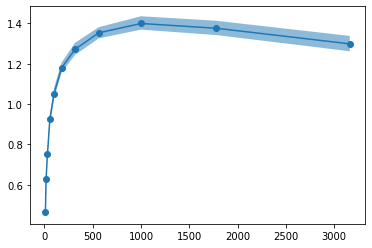

In [24]:
mean,cil,ciu = stats.bootstrap(h_N,n_times=100)
plt.plot(cluster_range,mean,marker='o')
plt.fill_between(cluster_range,cil,ciu,alpha=.5)
plt.show()

In [ ]:
n_worms = len(tseries_w)
K_range = np.arange(1,20)
h_K_N = np.zeros((n_worms,len(K_range),len(cluster_range)))
for k,K in enumerate(K_range):
    traj_matrix = embed.trajectory_matrix(ma.vstack(tseries_w),K = K-1)
    for kn,N in enumerate(cluster_range):
        labels_w = get_labels_w(cl.kmeans_knn_partition(traj_matrix,n_seeds=N),tseries_w)
        for kw in range(len(labels_w)):
            h_K_N[kw,k,kn] = op_calc.get_entropy(labels_w[kw])
        print(K,N)

1 10
1 17
1 31
1 56
1 100
1 177
1 316
1 562
1 1000
1 1778
1 3162
2 10
2 17
2 31
2 56
2 100
2 177
2 316
2 562
2 1000
2 1778
2 3162
3 10
3 17
3 31
3 56
3 100
3 177
3 316
3 562
3 1000
3 1778
3 3162
4 10
4 17
4 31
4 56
4 100
4 177
4 316
4 562
4 1000
4 1778
4 3162
5 10
5 17
5 31
5 56
5 100
5 177
5 316
5 562
5 1000
